In [1]:
#Import packages
import time
import os
import pickle
import random
import logging
import tensorflow as tf
import matplotlib.pyplot as plt
import segmentation_models as sm

import utils.parameters
from utils.model import s3ar_unet
from utils.save_load import save_h, load_h
from utils.eval import cost_compute, jacard_coef
from utils.test_loader import test_loader, read_image, read_mask, mask_parse

from utils.layers import (squeeze_excite_block, 
                          spatial_squeeze_excite_block, 
                          channel_spatial_squeeze_excite,
                          stem_block,
                          resnet_block,
                          attention_block,
                          single_conv_block,
                          fsm)

from utils.preprocess import (atoi, 
                              natural_keys, 
                              data_loader, 
                              read_image, 
                              read_mask, 
                              tf_parse, 
                              tf_dataset, 
                              read_and_rgb)

from glob import glob
from PIL import Image
from math import ceil
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import MeanIoU

from skimage import io
from skimage.io import imsave
from skimage.transform import resize
from tensorflow.keras.utils import normalize
from skimage.exposure import rescale_intensity
from skimage.segmentation import mark_boundaries
print("Packages successfully loaded")

tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

Segmentation Models: using `keras` framework.
Packages successfully loaded


# PARAMETER TWEAKING

In [2]:
#Parameter configurations
#Class
num_classes = 1

model_name = 'SeARUNet'
experiment_number = '51'

model_name = model_name + '-' + experiment_number

save_name =  model_name

print('Model to be trained is:', model_name)
print('Model is to be saved as:', save_name)

Model to be trained is: SeARUNet-51
Model is to be saved as: SeARUNet-51


In [3]:
#Set hyper-parameters
batch_size = 8
epochs = 25
optimizer = Adam
learning_rate = 1e-4
smooth = 1.0

print('Batch size is set to:', batch_size)
print('Epochs is set to:', epochs)
print('Optimizer is set to:', optimizer.__name__)
print('Learning Rate is set to:', learning_rate)
print('Smoothing is set to:', smooth)

Batch size is set to: 8
Epochs is set to: 25
Optimizer is set to: Adam
Learning Rate is set to: 0.0001
Smoothing is set to: 1.0


# DATASET PREPARATION

In [5]:
PATH = "ds/full/"

#Images
images = sorted(glob(os.path.join(PATH, "images/*")))
images.sort(key=natural_keys)

#Masks
masks = sorted(glob(os.path.join(PATH, "masks/*")))
masks.sort(key=natural_keys)

print(len(images))
print(len(masks))

55750
55750


# Preprocess

In [8]:
#split with labels
(train_x, train_y), (val_x, val_y)= data_loader(PATH)

print("Training data: ", len(train_x))
print("Validation data: ", len(val_x))

Training data:  52963
Validation data:  2787


# Check Train Data

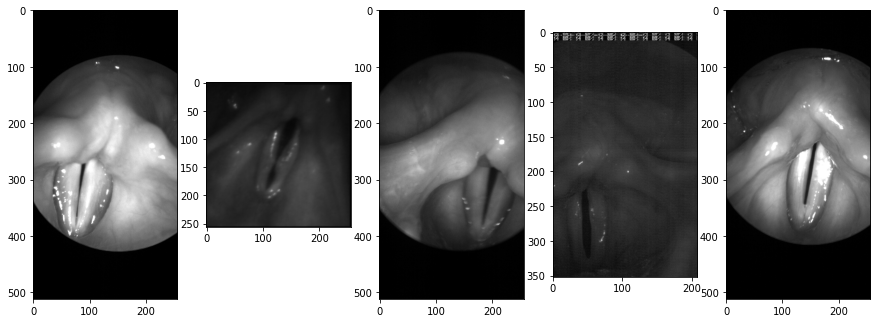

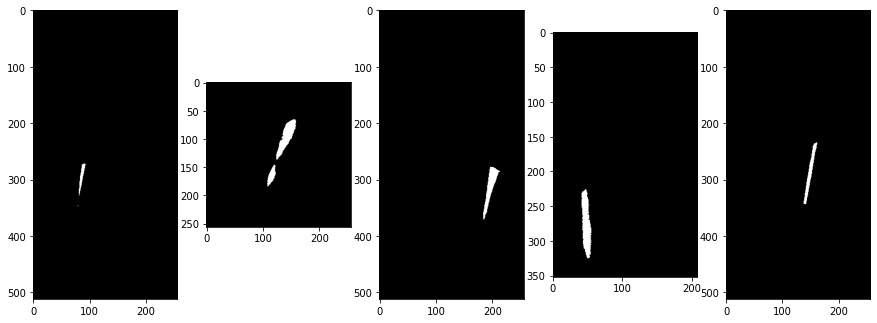

In [9]:
#Train data viewer
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 5, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

a = fig.add_subplot(1, 5, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 5, 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 5, 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 2.1)

a = fig.add_subplot(1, 5, 5)
imgplot = plt.imshow(read_and_rgb(train_x[4]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 5, 1)
imgplot = plt.imshow(read_and_rgb(train_y[0]))

a = fig.add_subplot(1, 5, 2)
imgplot = plt.imshow(read_and_rgb(train_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 5, 3)
imgplot = plt.imshow(read_and_rgb(train_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 5, 4)
imgplot = plt.imshow(read_and_rgb(train_y[3]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 5, 5)
imgplot = plt.imshow(read_and_rgb(train_y[4]))
imgplot.set_clim(0.0, 1.4)

# Check Validation Data

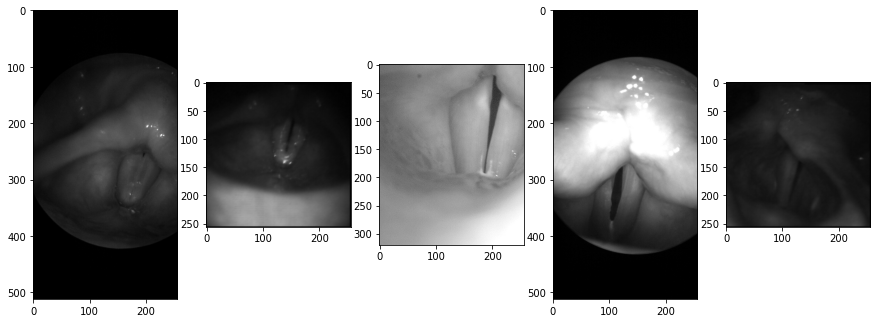

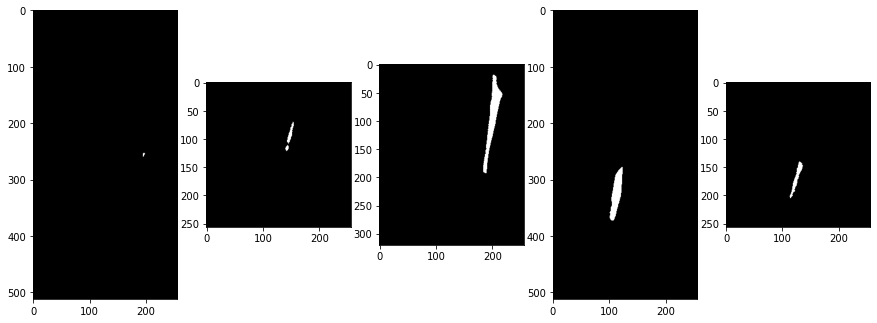

In [10]:
#Val data viewer
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 5, 1)
imgplot = plt.imshow(read_and_rgb(val_x[0]))

a = fig.add_subplot(1, 5, 2)
imgplot = plt.imshow(read_and_rgb(val_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 5, 3)
imgplot = plt.imshow(read_and_rgb(val_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 5, 4)
imgplot = plt.imshow(read_and_rgb(val_x[3]))
imgplot.set_clim(0.0, 2.1)

a = fig.add_subplot(1, 5, 5)
imgplot = plt.imshow(read_and_rgb(val_x[4]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 5, 1)
imgplot = plt.imshow(read_and_rgb(val_y[0]))

a = fig.add_subplot(1, 5, 2)
imgplot = plt.imshow(read_and_rgb(val_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 5, 3)
imgplot = plt.imshow(read_and_rgb(val_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 5, 4)
imgplot = plt.imshow(read_and_rgb(val_y[3]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 5, 5)
imgplot = plt.imshow(read_and_rgb(val_y[4]))
imgplot.set_clim(0.0, 1.4)

# Produce Datasets

In [11]:
#Create datasets
train_dataset = tf_dataset(train_x, train_y, batch=8)
val_dataset = tf_dataset(val_x, val_y, batch=8)

# BUILD AND COMPILE MODEL

In [19]:
#Initialize the model
print('-'*30)
print('Creating model...')
print('-'*30)
model = SeAR_UNet()
model.summary()

------------------------------
Creating model...
------------------------------
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 32), dtype=tf.float32, name=None), name='activation_4/Relu6:0', description="created by layer 'activation_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 32), dtype=tf.float32, name=None), name='activation_8/Relu6:0', description="created by layer 'activation_8'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 16), dtype=tf.float32, name=None), name='activation_12/Relu6:0', description="created by layer 'activation_12'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 8), dtype=tf.float32, name=None), name='activation_16/Relu6:0', description="created by layer 'activation_16'")
KerasTensor(type_spec=TensorSpec(shape=(None, 2, 2, 8), dtype=tf.float32, name=None), name='activation_18/Relu6:0', description="created by layer 'activation_18'")
Model: "SeARUNet-51"
____________________________________________________________________________

                                                                  'batch_normalization_4[0][0]']  
                                                                                                  
 global_average_pooling2d_1 (Gl  (None, 32)          0           ['add_2[0][0]']                  
 obalAveragePooling2D)                                                                            
                                                                                                  
 reshape_1 (Reshape)            (None, 1, 1, 32)     0           ['global_average_pooling2d_1[0][0
                                                                 ]']                              
                                                                                                  
 dense_2 (Dense)                (None, 1, 1, 4)      128         ['reshape_1[0][0]']              
                                                                                                  
 dense_3 (

                                                                                                  
 separable_conv2d_15 (Separable  (None, 16, 16, 32)  488         ['activation_5[0][0]']           
 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 16, 16, 32)  128         ['separable_conv2d_15[0][0]']    
 rmalization)                                                                                     
                                                                                                  
 activation_6 (Activation)      (None, 16, 16, 32)   0           ['batch_normalization_8[0][0]']  
                                                                                                  
 separable_conv2d_17 (Separable  (None, 16, 16, 32)  296         ['max_pooling2d[0][0]']          
 Conv2D)  

 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_11 (BatchN  (None, 16, 16, 32)  128         ['separable_conv2d_24[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 activation_8 (Activation)      (None, 16, 16, 32)   0           ['batch_normalization_11[0][0]'] 
                                                                                                  
 add_9 (Add)                    (None, 16, 16, 32)   0           ['activation_8[0][0]',           
                                                                  'add_7[0][0]']                  
                                                                                                  
 separable

 separable_conv2d_33 (Separable  (None, 8, 8, 4)     40          ['activation_11[0][0]']          
 Conv2D)                                                                                          
                                                                                                  
 lambda_2 (Lambda)              (None, 64, 64)       0           ['dot_4[0][0]']                  
                                                                                                  
 reshape_14 (Reshape)           (None, 64, 4)        0           ['separable_conv2d_33[0][0]']    
                                                                                                  
 dot_5 (Dot)                    (None, 64, 4)        0           ['lambda_2[0][0]',               
                                                                  'reshape_14[0][0]']             
                                                                                                  
 reshape_1

                                                                                                  
 batch_normalization_20 (BatchN  (None, 4, 4, 4)     16          ['separable_conv2d_41[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 activation_15 (Activation)     (None, 4, 4, 4)      0           ['batch_normalization_20[0][0]'] 
                                                                                                  
 separable_conv2d_42 (Separable  (None, 4, 4, 2)     12          ['activation_15[0][0]']          
 Conv2D)                                                                                          
                                                                                                  
 separable_conv2d_43 (Separable  (None, 4, 4, 2)     12          ['activation_15[0][0]']          
 Conv2D)  

                                                                                                  
 reshape_24 (Reshape)           (None, 2, 2, 2)      0           ['dot_9[0][0]']                  
                                                                                                  
 separable_conv2d_52 (Separable  (None, 2, 2, 4)     10          ['reshape_24[0][0]']             
 Conv2D)                                                                                          
                                                                                                  
 add_18 (Add)                   (None, 2, 2, 4)      0           ['activation_17[0][0]',          
                                                                  'separable_conv2d_52[0][0]']    
                                                                                                  
 separable_conv2d_53 (Separable  (None, 2, 2, 8)     140         ['add_18[0][0]']                 
 Conv2D)  

                                                                  'dense_13[0][0]']               
                                                                                                  
 multiply_14 (Multiply)         (None, 2, 2, 8)      0           ['multiply_12[0][0]',            
                                                                  'separable_conv2d_59[0][0]']    
                                                                                                  
 add_22 (Add)                   (None, 2, 2, 8)      0           ['multiply_13[0][0]',            
                                                                  'multiply_14[0][0]']            
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 4, 4, 8)     264         ['add_22[0][0]']                 
 ose)                                                                                             
          

 multiply_18 (Multiply)         (None, 4, 4, 8)      0           ['separable_conv2d_64[0][0]',    
                                                                  'separable_conv2d_65[0][0]']    
                                                                                                  
 depthwise_conv2d_2 (DepthwiseC  (None, 2, 2, 8)     520         ['separable_conv2d_66[0][0]']    
 onv2D)                                                                                           
                                                                                                  
 add_26 (Add)                   (None, 4, 4, 8)      0           ['multiply_17[0][0]',            
                                                                  'multiply_18[0][0]']            
                                                                                                  
 up_sampling2d_1 (UpSampling2D)  (None, 4, 4, 8)     0           ['depthwise_conv2d_2[0][0]']     
          

 reshape_30 (Reshape)           (None, 1, 1, 16)     0           ['global_average_pooling2d_10[0][
                                                                 0]']                             
                                                                                                  
 dense_20 (Dense)               (None, 1, 1, 2)      32          ['reshape_30[0][0]']             
                                                                                                  
 dense_21 (Dense)               (None, 1, 1, 16)     32          ['dense_20[0][0]']               
                                                                                                  
 separable_conv2d_73 (Separable  (None, 8, 8, 1)     32          ['add_30[0][0]']                 
 Conv2D)                                                                                          
                                                                                                  
 multiply_

                                                                                                  
 multiply_28 (Multiply)         (None, 8, 8, 8)      0           ['multiply_26[0][0]',            
                                                                  'separable_conv2d_79[0][0]']    
                                                                                                  
 add_34 (Add)                   (None, 8, 8, 8)      0           ['multiply_27[0][0]',            
                                                                  'multiply_28[0][0]']            
                                                                                                  
 conv2d_transpose_2 (Conv2DTran  (None, 16, 16, 8)   264         ['add_34[0][0]']                 
 spose)                                                                                           
                                                                                                  
 add_35 (A

                                                                  'separable_conv2d_85[0][0]']    
                                                                                                  
 depthwise_conv2d_4 (DepthwiseC  (None, 8, 8, 8)     520         ['separable_conv2d_86[0][0]']    
 onv2D)                                                                                           
                                                                                                  
 add_38 (Add)                   (None, 16, 16, 8)    0           ['multiply_31[0][0]',            
                                                                  'multiply_32[0][0]']            
                                                                                                  
 up_sampling2d_3 (UpSampling2D)  (None, 16, 16, 8)   0           ['depthwise_conv2d_4[0][0]']     
                                                                                                  
 separable

                                                                 0]']                             
                                                                                                  
 dense_32 (Dense)               (None, 1, 1, 4)      128         ['reshape_36[0][0]']             
                                                                                                  
 dense_33 (Dense)               (None, 1, 1, 32)     128         ['dense_32[0][0]']               
                                                                                                  
 separable_conv2d_93 (Separable  (None, 32, 32, 1)   64          ['add_41[0][0]']                 
 Conv2D)                                                                                          
                                                                                                  
 multiply_36 (Multiply)         (None, 32, 32, 32)   0           ['add_41[0][0]',                 
          

In [20]:
#Calculate the cost
cost_compute()

FLOPS: 0.21 GFLOPS


# COMPILE MODEL

In [22]:
#Compile the model
model.compile(optimizer=optimizer(learning_rate=learning_rate), 
              loss=tf.keras.losses.BinaryFocalCrossentropy(), 
              metrics=['accuracy', 
                       sm.metrics.Precision(threshold = 0.5, smooth=smooth),
                       sm.metrics.Recall(threshold = 0.5, smooth=smooth),
                       sm.metrics.FScore(threshold = 0.5, smooth=smooth, name='F1/DSC'),   
                       sm.metrics.IOUScore(threshold = 0.5, smooth=smooth, name='IOU/JaccardIndex'),
                       sm.metrics.IOUScore(threshold = 0.5, smooth=smooth, per_image=True, name='MeanIOU')])  

print('Selected optimizer:', optimizer.__name__)
print('Learning rate:', learning_rate)

print('-'*26)
print(' '*4 +'--Model compiled--')
print('-'*26)

Selected optimizer: Adam
Learning rate: 0.0001
--------------------------
    --Model compiled--
--------------------------


# PREPARE MODEL DIRECTORY TO SAVE

In [23]:
#Prepare directory for saving the model.
model_dir = 'model/'

if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    print('Model directory', model_dir, 'successfully created')
else:
    print('Model directory already exist, no new directory made.')

print()
print('-'*49)
print('Model directory is available for saving the model!')
print('-'*49)

Model directory already exist, no new directory made.

-------------------------------------------------
Model directory is available for saving the model!
-------------------------------------------------


# SET GENERATORS FOR TRAINING

In [24]:
train_steps = (len(train_x) // batch_size)
val_steps = (len(val_x) // batch_size)

# BEGIN TRAINING

In [25]:
#Train the model with the preprocessed data
print('-'*30)
print('Training model', save_name, '.'*5)
print('-'*30)

#Set timer
start_time = time.time()

history = model.fit(train_dataset,   
                  epochs=epochs,
                  steps_per_epoch=train_steps, 
                  validation_steps=val_steps,
                  validation_data=val_dataset,
                  verbose=1)

elapsed_time = time.time() - start_time
train_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print()
print()
print(train_time, 'train_time')
print()
print(elapsed_time, 'Seconds')
print()
print()
print("MODEL SERIALIZING WAIT FOR A MOMENT...")
print()
print()
print('-'*130)
print(' '*53, model_name, 'successfully trained...')
print('-'*130)

------------------------------
Training model SeARUNet-51 .....
------------------------------
Epoch 1/25
6620/6620 [==============================] - 800s 119ms/step - loss: 0.0061 - accuracy: 0.9918 - precision: 0.7686 - recall: 0.5069 - F1/DSC: 0.5693 - IOU/JaccardIndex: 0.4294 - MeanIOU: 0.3680 - val_loss: 0.0030 - val_accuracy: 0.9957 - val_precision: 0.9246 - val_recall: 0.4727 - val_F1/DSC: 0.6154 - val_IOU/JaccardIndex: 0.4541 - val_MeanIOU: 0.4112
Epoch 2/25
6620/6620 [==============================] - 775s 117ms/step - loss: 0.0016 - accuracy: 0.9967 - precision: 0.8405 - recall: 0.7659 - F1/DSC: 0.7949 - IOU/JaccardIndex: 0.6656 - MeanIOU: 0.5864 - val_loss: 0.0015 - val_accuracy: 0.9969 - val_precision: 0.9153 - val_recall: 0.6770 - val_F1/DSC: 0.7725 - val_IOU/JaccardIndex: 0.6343 - val_MeanIOU: 0.5637
Epoch 3/25
6620/6620 [==============================] - 778s 118ms/step - loss: 0.0012 - accuracy: 0.9972 - precision: 0.8646 - recall: 0.8194 - F1/DSC: 0.8375 - IOU/Jaccard

Epoch 23/25
6620/6620 [==============================] - 796s 120ms/step - loss: 4.2285e-04 - accuracy: 0.9981 - precision: 0.9234 - recall: 0.9147 - F1/DSC: 0.9185 - IOU/JaccardIndex: 0.8502 - MeanIOU: 0.8011 - val_loss: 4.8842e-04 - val_accuracy: 0.9981 - val_precision: 0.9045 - val_recall: 0.9302 - val_F1/DSC: 0.9165 - val_IOU/JaccardIndex: 0.8470 - val_MeanIOU: 0.8030
Epoch 24/25
6620/6620 [==============================] - 799s 121ms/step - loss: 4.1398e-04 - accuracy: 0.9981 - precision: 0.9240 - recall: 0.9157 - F1/DSC: 0.9193 - IOU/JaccardIndex: 0.8515 - MeanIOU: 0.8025 - val_loss: 4.6550e-04 - val_accuracy: 0.9981 - val_precision: 0.9042 - val_recall: 0.9308 - val_F1/DSC: 0.9167 - val_IOU/JaccardIndex: 0.8473 - val_MeanIOU: 0.8036
Epoch 25/25
6620/6620 [==============================] - 799s 121ms/step - loss: 4.1004e-04 - accuracy: 0.9981 - precision: 0.9243 - recall: 0.9162 - F1/DSC: 0.9197 - IOU/JaccardIndex: 0.8523 - MeanIOU: 0.8037 - val_loss: 4.9863e-04 - val_accuracy: 0

# Evaluate the model

In [26]:
val_dataset = tf_dataset(val_x, val_y, batch=8)

val_steps = (len(val_x)//batch_size)
if len(val_x) % batch_size != 0:
    val_steps += 1

In [27]:
#Evaluate the model
print('Evaluating', save_name)
print()
print()
model.evaluate(val_dataset, steps=val_steps, return_dict=True)

Evaluating SeARUNet-51


349/349 [==============================] - 11s 31ms/step - loss: 4.9884e-04 - accuracy: 0.9981 - precision: 0.9066 - recall: 0.9291 - F1/DSC: 0.9172 - IOU/JaccardIndex: 0.8481 - MeanIOU: 0.8058


{'loss': 0.0004988433211110532,
 'accuracy': 0.9980985522270203,
 'precision': 0.9066117405891418,
 'recall': 0.9291308522224426,
 'F1/DSC': 0.9171629548072815,
 'IOU/JaccardIndex': 0.8480625152587891,
 'MeanIOU': 0.8057516813278198}

# PLOT RESULTS

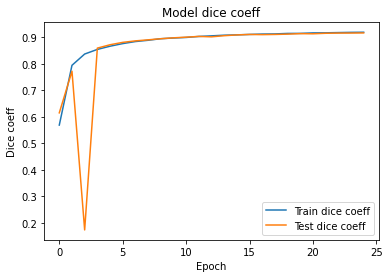

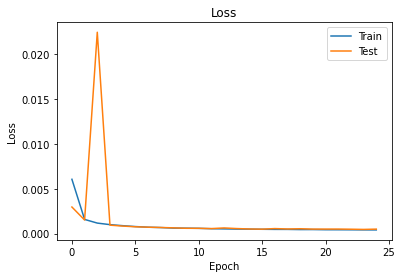

In [28]:
#Plot accuracy results
plt.plot(history.history['F1/DSC'])
plt.plot(history.history['val_F1/DSC'])
plt.title('Model dice coeff')
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(['Train dice coeff', 'Test dice coeff'], loc='best')
plt.show()

#Plot loss results
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

# Save Model and History

In [29]:
#Sets the directory to save the model
save_folder = 'model/' + save_name + '/'
saved_model = save_folder + save_name + '.h5'
print('File is to be saved in ', save_folder, 'folder ' + 'as', save_name)

File is to be saved in  model/SeARUNet-51/ folder as SeARUNet-51


In [30]:
#Saves the entire structure and weights
model.save(saved_model)
print('successfully saved in as', saved_model)

successfully saved in as model/SeARUNet-51/SeARUNet-51.h5


In [31]:
#Save the History
save_h(save_folder, history.history)

history saved


In [32]:
#Load the History
history = load_h(model_name)

print(model_name, "history loaded!")

SeARUNet-51 history loaded!


In [33]:
# Loads the entire structure and weights
model = load_model(saved_model, compile=False)

# EVALUATION

In [35]:
TEST_PATH = "test/"
(test_x, test_y) = test_loader(TEST_PATH)

print("Test images: ", len(test_x))
print("Test mask: ", len(test_y))

Test images:  3500
Test mask:  3500


In [36]:
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

In [37]:
test_step = (len(test_x) // batch_size)

In [39]:
#Compile the model
model.compile(optimizer=optimizer(learning_rate=learning_rate), 
              loss=tf.keras.losses.BinaryFocalCrossentropy(), 
              metrics=['accuracy', 
                       sm.metrics.Precision(threshold = 0.5, smooth=smooth),
                       sm.metrics.Recall(threshold = 0.5, smooth=smooth),
                       sm.metrics.FScore(threshold = 0.5, smooth=smooth, name='F1/DSC'),   
                       sm.metrics.IOUScore(threshold = 0.5, smooth=smooth, name='IOU/JaccardIndex'),
                       sm.metrics.IOUScore(threshold = 0.5, smooth=smooth, per_image=True, name='MeanIOU')])  

print('Selected optimizer:', optimizer.__name__)
print('Learning rate:', learning_rate)

print('-'*26)
print(' '*4 +'--Model compiled--')
print('-'*26)

Selected optimizer: Adam
Learning rate: 0.0001
--------------------------
    --Model compiled--
--------------------------


In [40]:
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

test_steps = (len(test_x)//batch_size)
if len(test_x) % batch_size != 0:
    test_steps += 1

In [41]:
model.evaluate(test_dataset, steps=test_steps, return_dict=True)

438/438 [==============================] - 24s 49ms/step - loss: 0.0013 - accuracy: 0.9970 - precision: 0.8728 - recall: 0.8909 - F1/DSC: 0.8794 - IOU/JaccardIndex: 0.7895 - MeanIOU: 0.7079


{'loss': 0.0013082147343084216,
 'accuracy': 0.997032642364502,
 'precision': 0.8727861642837524,
 'recall': 0.8909156322479248,
 'F1/DSC': 0.8794224262237549,
 'IOU/JaccardIndex': 0.7894947528839111,
 'MeanIOU': 0.7078663110733032}